<img src="https://swan.web.cern.ch/sites/swan.web.cern.ch/files/pictures/logo_swan_letters.png" alt="SWAN" style="float: left; width: 20%; margin-right: 15%; margin-left: 15%; margin-bottom: 2.0em;">
<img src="https://spark.apache.org/images/spark-logo-trademark.png" alt="EP-SFT" style="float: left; width: 25%; margin-right: 15%; margin-bottom: 2.0em;">
<p style="clear: both;">
<div style="text-align:center"><h1>Physics analysis with Apache Spark using Coffea and Laurelin packages from Fermilab</h1></div>
<div style="text-align:center"><i>Author: Lindsey Gray; Contact: Lindsey Gray / Prasanth Kothuri</i></div>
<hr style="border-top-width: 4px; border-top-color: #34609b;">

# Dimuon spectrum

This code is a columnar adaptation of [a ROOT tutorial](https://root.cern.ch/doc/master/df102__NanoAODDimuonAnalysis_8py.html) showcasing the awkward array toolset, and utilizing Coffea [histograms](https://coffeateam.github.io/coffea/modules/coffea.hist.html).
This also shows the analysis object syntax implemented by Coffea [JaggedCandidateArray](https://coffeateam.github.io/coffea/api/coffea.analysis_objects.JaggedCandidateMethods.html), and the usage of custom [accumulators](https://coffeateam.github.io/coffea/api/coffea.processor.AccumulatorABC.html) other than histograms.  Further, it introduces the [processor](https://coffeateam.github.io/coffea/api/coffea.processor.ProcessorABC.html) concept and the interface to apache spark.

#### SWAN env: LCG96 Python3 stack and Cloud Containers cluster

In [ ]:
# Run this cell if you do not have coffea installed (e.g. on SWAN with LCG 96Python3 stack)
!pip install --user --upgrade coffea

# spark.jars.packages doesnt work with Spark 2.4 with kubernetes
!wget -N https://repo1.maven.org/maven2/edu/vanderbilt/accre/laurelin/0.5.1/laurelin-0.5.1.jar && \
wget -N https://repo1.maven.org/maven2/org/apache/logging/log4j/log4j-api/2.11.2/log4j-api-2.11.2.jar && \
wget -N https://repo1.maven.org/maven2/org/apache/logging/log4j/log4j-core/2.11.2/log4j-core-2.11.2.jar && \
wget -N https://repo1.maven.org/maven2/org/lz4/lz4-java/1.5.1/lz4-java-1.5.1.jar && \
wget -N https://repo1.maven.org/maven2/org/tukaani/xz/1.2/xz-1.2.jar

In [1]:
# Run this cell before establishing spark connection

import os
os.environ['PYTHONPATH'] = os.environ['PYTHONPATH'] + ':' + '/usr/local/lib/python3.6/site-packages'

In [2]:
import time

%matplotlib inline
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor

In [3]:
# Look at ProcessorABC documentation to see the expected methods and what they are supposed to do
class DimuonProcessor(processor.ProcessorABC):
    def __init__(self):
        self._columns = ['nMuon', 'Muon_pt', 'Muon_eta', 'Muon_phi', 'Muon_mass', 'Muon_charge']
        dataset_axis = hist.Cat("dataset", "Primary dataset")
        mass_axis = hist.Bin("mass", r"$m_{\mu\mu}$ [GeV]", 30000, 0.25, 300)
        
        self._accumulator = processor.dict_accumulator({
            'mass': hist.Hist("Counts", dataset_axis, mass_axis),
            'cutflow': processor.defaultdict_accumulator(int),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    @property
    def columns(self):
        return self._columns
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        muons = JaggedCandidateArray.candidatesfromcounts(
            df['nMuon'],
            pt=df['Muon_pt'].content,
            eta=df['Muon_eta'].content,
            phi=df['Muon_phi'].content,
            mass=df['Muon_mass'].content,
            charge=df['Muon_charge'].content,
            )
        
        output['cutflow']['all events'] += muons.size
        
        twomuons = (muons.counts == 2)
        output['cutflow']['two muons'] += twomuons.sum()
        
        opposite_charge = twomuons & (muons['charge'].prod() == -1)
        output['cutflow']['opposite charge'] += opposite_charge.sum()
        
        dimuons = muons[opposite_charge].distincts()
        output['mass'].fill(dataset=dataset, mass=dimuons.mass.flatten())
        
        return output

    def postprocess(self, accumulator):
        return accumulator


NOW IT IS TIME TO START SPARK CLUSTER CONNECTION


When using SWAN, click on the 5-point start icon in Jupyter notebook


In [4]:
import pyspark.sql
from pyarrow.compat import guid
from coffea.processor.spark.detail import _spark_initialize, _spark_stop
from coffea.processor.spark.spark_executor import spark_executor

"""
# NOT needed on SWAN, spark config is offloaded to spark connector

spark_config = pyspark.sql.SparkSession.builder \
    .appName('spark-executor-test-%s' % guid()) \
    .master('local[*]') \
    .config('spark.driver.memory', '4g') \
    .config('spark.executor.memory', '4g') \
    .config('spark.sql.execution.arrow.enabled','true') \
    .config('spark.sql.execution.arrow.maxRecordsPerBatch', 200000)

spark = _spark_initialize(config=spark, log_level='WARN', 
                          spark_progress=False, laurelin_version='0.5.1')
"""
partitionsize = 200000
thread_workers = 2

tstart = time.time()    

fileset = {
    'DoubleMuon': { 'files': [
        'root://eospublic.cern.ch//eos/root-eos/cms_opendata_2012_nanoaod/Run2012B_DoubleMuParked.root',
        'root://eospublic.cern.ch//eos/root-eos/cms_opendata_2012_nanoaod/Run2012C_DoubleMuParked.root',
                             ], 
                    'treename': 'Events'
                  }
}

output = processor.run_spark_job(fileset, DimuonProcessor(), spark_executor, 
                                 spark=spark, partitionsize=partitionsize, thread_workers=thread_workers,
                                 executor_args={'file_type': 'edu.vanderbilt.accre.laurelin.Root', 'cache': False}
                                )

elapsed = time.time() - tstart
print(output)

/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/pyarrow/__init__.py:152: UserWarning: pyarrow.open_stream is deprecated, please use pyarrow.ipc.open_stream
  warnings.warn("pyarrow.open_stream is deprecated, please use "



{'mass': <Hist (dataset,mass) instance at 0x7f0e8cac9f28>, 'cutflow': defaultdict(<class 'int'>, {'all events': 66128870, 'two muons': 33370298, 'opposite charge': 25794885})}


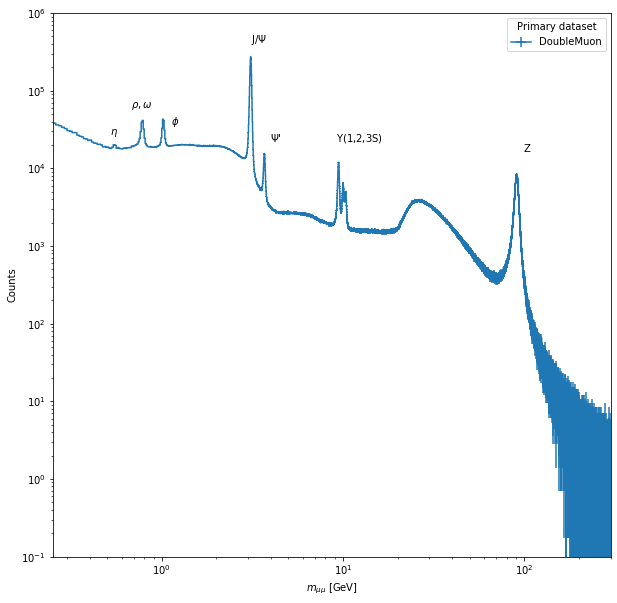

In [5]:
ax = hist.plot1d(output['mass'], overlay='dataset')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(0.1, 1e6)

import matplotlib.pyplot as plt
ax.figure.set_size_inches(10,10)
txt_opts = {'horizontalalignment': 'center',
            'verticalalignment': 'center',
            'transform': ax.transAxes}
plt.text(0.85, 0.75, 'Z', **txt_opts)
plt.text(0.55, 0.77, r"$\Upsilon$(1,2,3S)", **txt_opts)
plt.text(0.37, 0.95, r"J/$\Psi$", **txt_opts)
plt.text(0.40, 0.77, r"$\Psi$'", **txt_opts)
plt.text(0.22, 0.80, r"$\phi$", **txt_opts)
plt.text(0.16, 0.83, r"$\rho,\omega$", **txt_opts)
plt.text(0.11, 0.78, r"$\eta$", **txt_opts);

In [6]:
print("Events/s:", output['cutflow']['all events']/elapsed)

Events/s: 840071.4636416258
